Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   name            231636 non-null  object
 1   id              231637 non-null  int64 
 2   minutes         231637 non-null  int64 
 3   contributor_id  231637 non-null  int64 
 4   submitted       231637 non-null  object
 5   tags            231637 non-null  object
 6   nutrition       231637 non-null  object
 7   n_steps         231637 non-null  int64 
 8   steps           231637 non-null  object
 9   description     226658 non-null  object
 10  ingredients     231637 non-null  object
 11  n_ingredients   231637 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 21.2+ MB
None

Summary Statistics:
                  id       minutes  contributor_id        n_steps  \
count  231637.000000  2.316370e+05    2.316370e+05  231637.000000   
mean   222014.708984  9.39

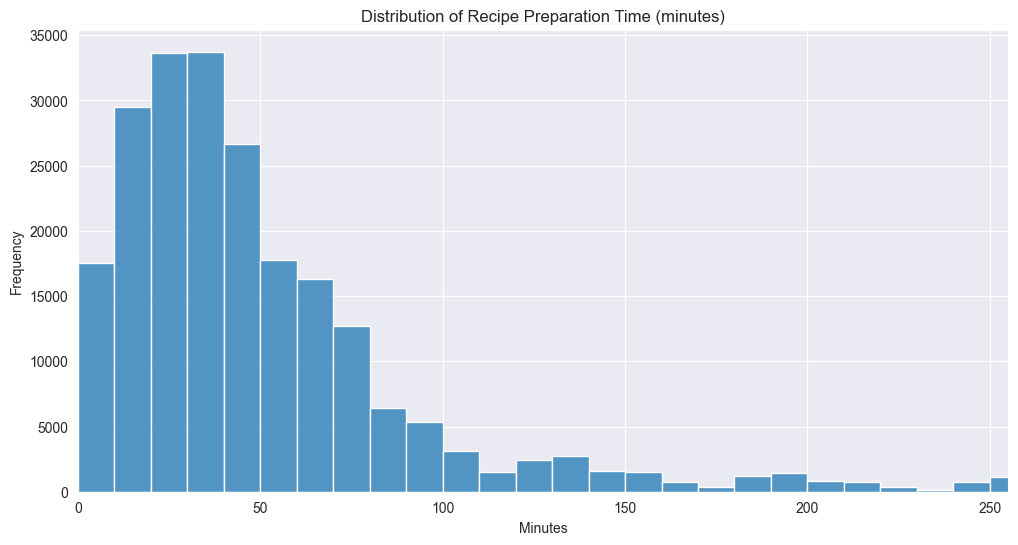

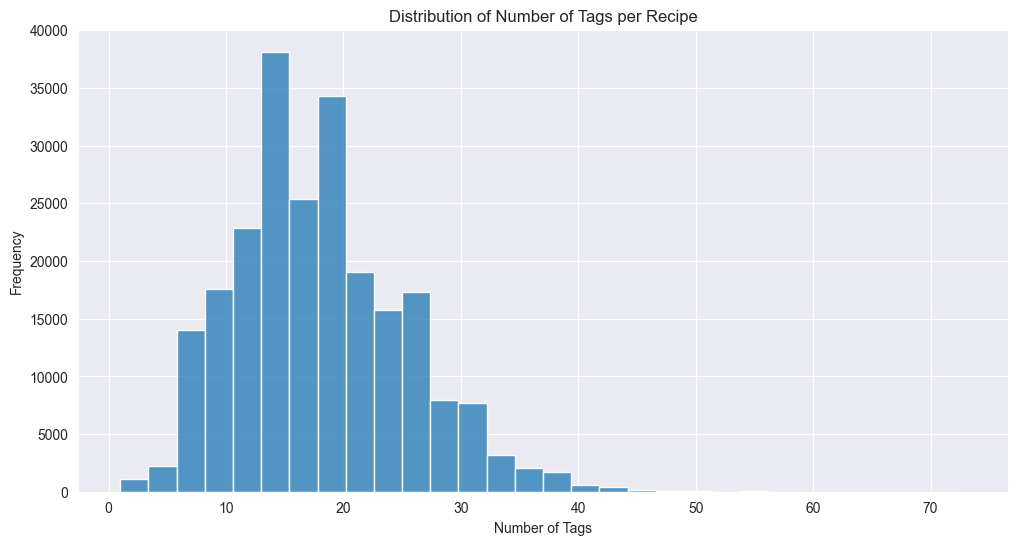

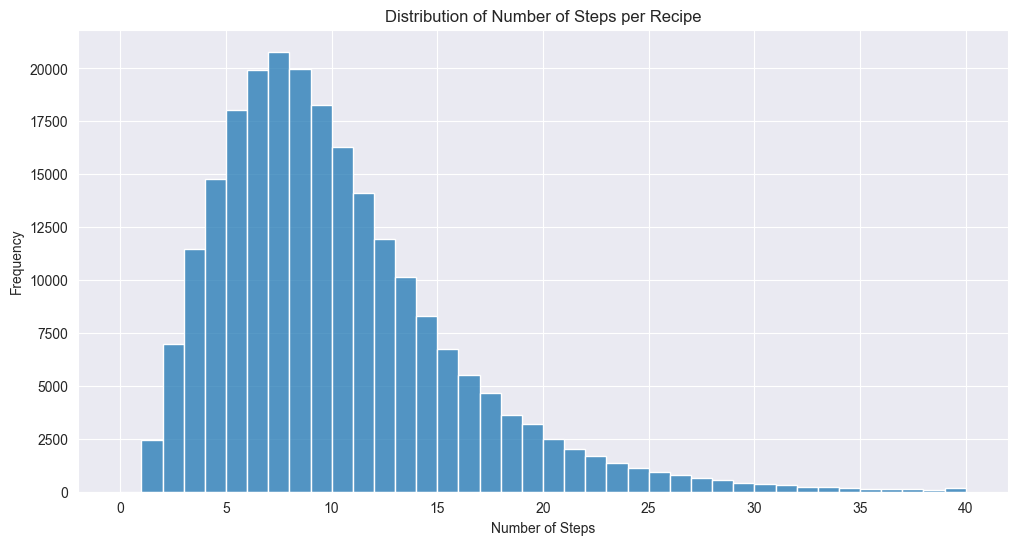

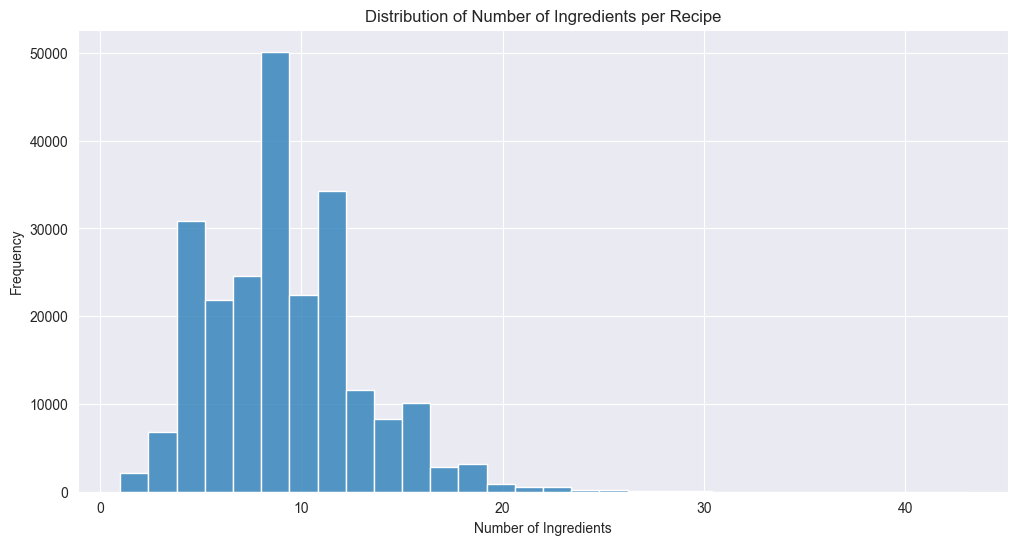

In [19]:
# Task 1

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
recipes_df = pd.read_csv('RAW_recipes.csv')

# Display basic information about the dataset
print("Dataset Overview:")
print(recipes_df.info())
print("\nSummary Statistics:")
print(recipes_df.describe())

# Handling any missing values or data type issues
recipes_df = recipes_df.dropna(subset=['minutes', 'n_steps', 'n_ingredients'])  # Dropping any rows with missing values in critical columns

minutes_data = []
steps_data = []
for  minutes in recipes_df['minutes']:
    if minutes > 600:  # Choose a threshold that makes sense for your data
        continue  
    
    minutes_data.append(minutes)
   
for  steps in recipes_df['n_steps']:
    if steps > 40:  # Choose a threshold that makes sense for your data
        continue  
    steps_data.append(steps)
    
    
# Feature 1: Distribution of 'minutes' (time taken for recipes)
plt.figure(figsize=(12, 6))
sns.histplot(minutes_data, bins=60, kde=False)
plt.title('Distribution of Recipe Preparation Time (minutes)')
plt.xlabel('Minutes')
plt.ylabel('Frequency')
plt.xlim(0, recipes_df['minutes'].quantile(.95))  # Limiting x-axis to 95th percentile for clarity
plt.show()


# Feature 2: Distribution of 'tags' (number of tags per recipe)
# Counting number of tags per recipe
recipes_df['tag_count'] = recipes_df['tags'].apply(lambda x: len(eval(x)) if pd.notna(x) else 0)
plt.figure(figsize=(12, 6))
sns.histplot(recipes_df['tag_count'], bins=30, kde=False)
plt.title('Distribution of Number of Tags per Recipe')
plt.xlabel('Number of Tags')
plt.ylabel('Frequency')
plt.show()

# Feature 3: Distribution of 'n_steps' (number of steps per recipe)
plt.figure(figsize=(12, 6))
sns.histplot(steps_data, bins=40, kde=False)
plt.title('Distribution of Number of Steps per Recipe')
plt.xlabel('Number of Steps')
plt.ylabel('Frequency')
plt.show()

# Feature 4: Distribution of 'n_ingredients' (number of ingredients per recipe)
plt.figure(figsize=(12, 6))
sns.histplot(recipes_df['n_ingredients'], bins=30, kde=False)
plt.title('Distribution of Number of Ingredients per Recipe')
plt.xlabel('Number of Ingredients')
plt.ylabel('Frequency')
plt.show()




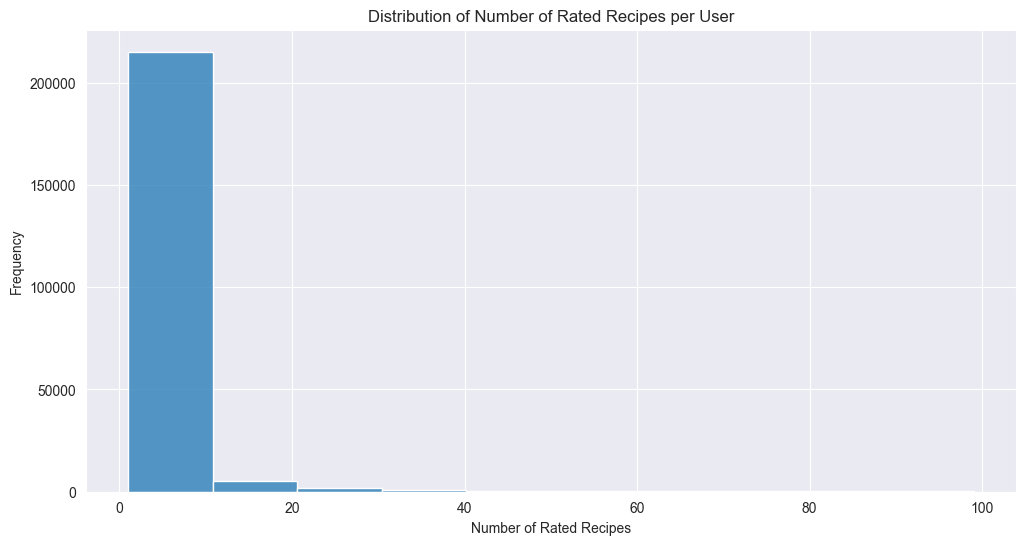

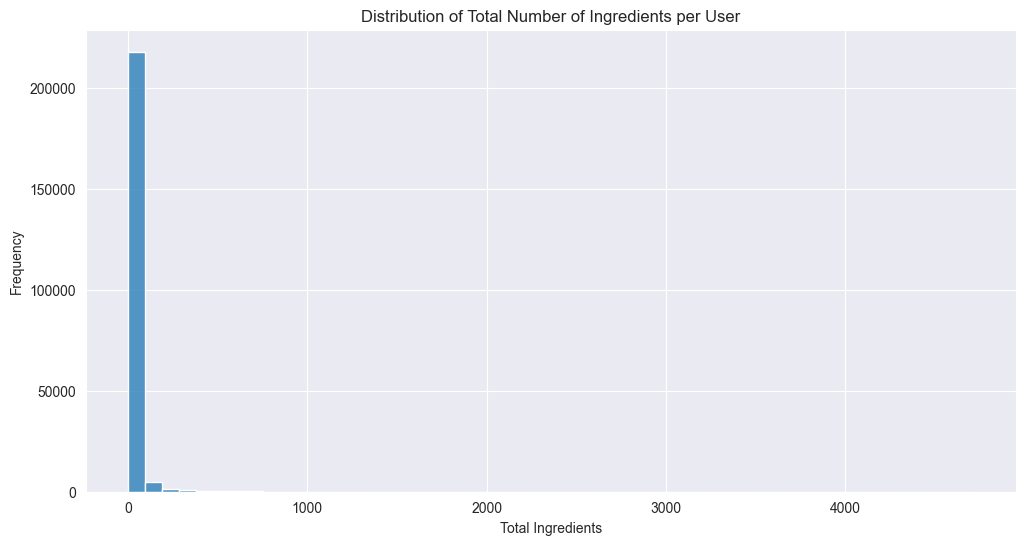

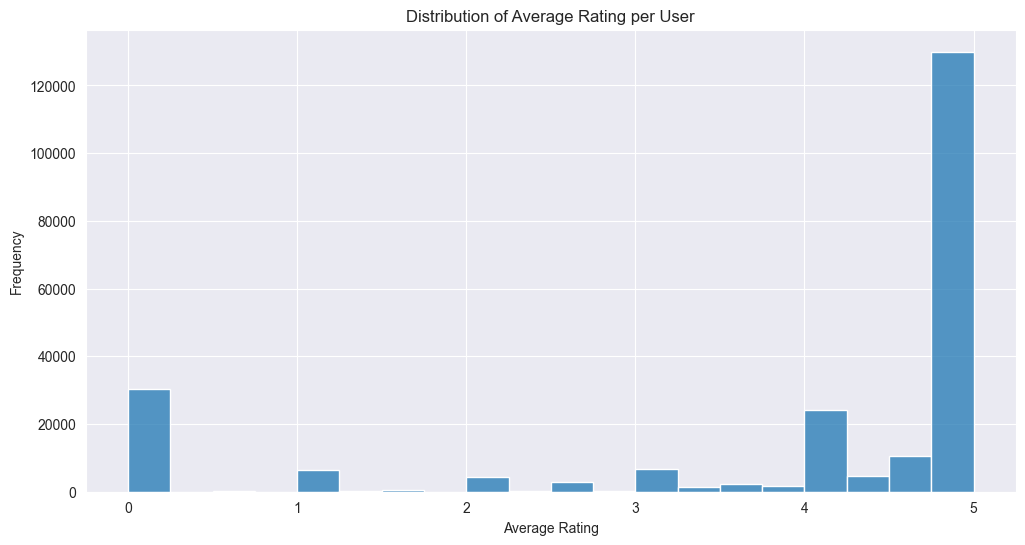

In [23]:
#Task 2
# Load datasets
recipes_df = pd.read_csv('RAW_recipes_filtered.csv')
interactions_df = pd.read_csv('RAW_interactions.csv')

recipes_df.head().to_csv('recipe_head.csv', index=False)
interactions_df.head().to_csv('interactions_head.csv', index=False)


# Merge datasets on 'recipe_id' to combine user interaction data with recipe data
merged_df = interactions_df.merge(recipes_df, left_on='recipe_id', right_on='id', how='left')

# Group by 'user_id' to aggregate the required data
user_data = merged_df.groupby('user_id').agg(
    rated_recipes=('recipe_id', list),
    ingredients=('ingredients', lambda x: list(set(ingredient for ingredients in x.dropna() for ingredient in eval(ingredients)))),
    rating_list=('rating', list)
).reset_index()

# Calculate additional columns for analysis
user_data['num_rated_items'] = user_data['rated_recipes'].apply(len)
user_data['total_ingredients'] = user_data['ingredients'].apply(len)
user_data['average_rating'] = user_data['rating_list'].apply(lambda x: sum(x) / len(x) if x else 0)

# Save the new user profile dataset
user_data.to_csv('User_Data.csv', index=False)

# Visualization of key features
user_Num_rated = user_data['num_rated_items']
user_Num_rated = user_Num_rated[user_Num_rated <100]

plt.figure(figsize=(12, 6))
sns.histplot(user_Num_rated, bins=10, kde=False)
plt.title('Distribution of Number of Rated Recipes per User')
plt.xlabel('Number of Rated Recipes')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(user_data['total_ingredients'], bins=50, kde=False)
plt.title('Distribution of Total Number of Ingredients per User')
plt.xlabel('Total Ingredients')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(user_data['average_rating'], bins=20, kde=False)
plt.title('Distribution of Average Rating per User')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()


/var/folders/9p/pz2gm6b53b938gprkjnpppzr0000gn/T/ipykernel_26218/1045667796.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=interactions_df, palette='viridis')


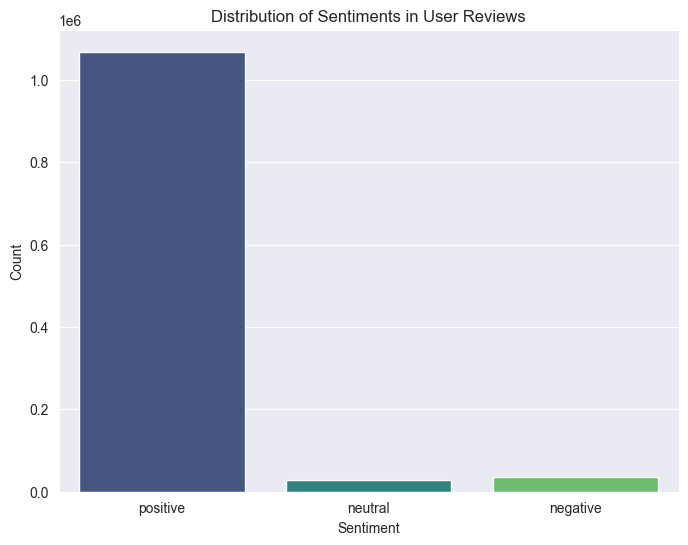

In [3]:
#Task 3
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

# Load the interactions dataset
interactions_df = pd.read_csv('RAW_interactions.csv')

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Define a function to classify sentiment based on VADER polarity score
def get_sentiment(review):
    if pd.isna(review):
        return "neutral"  # Treat missing reviews as neutral
    score = analyzer.polarity_scores(review)['compound']
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"

# Apply the sentiment function to the review column
interactions_df['sentiment'] = interactions_df['review'].apply(get_sentiment)

# Save the dataset with sentiment labels
interactions_df.to_csv('Interactions_with_Sentiment.csv', index=False)

# Visualization of sentiment distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=interactions_df, palette='viridis')
plt.title('Distribution of Sentiments in User Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

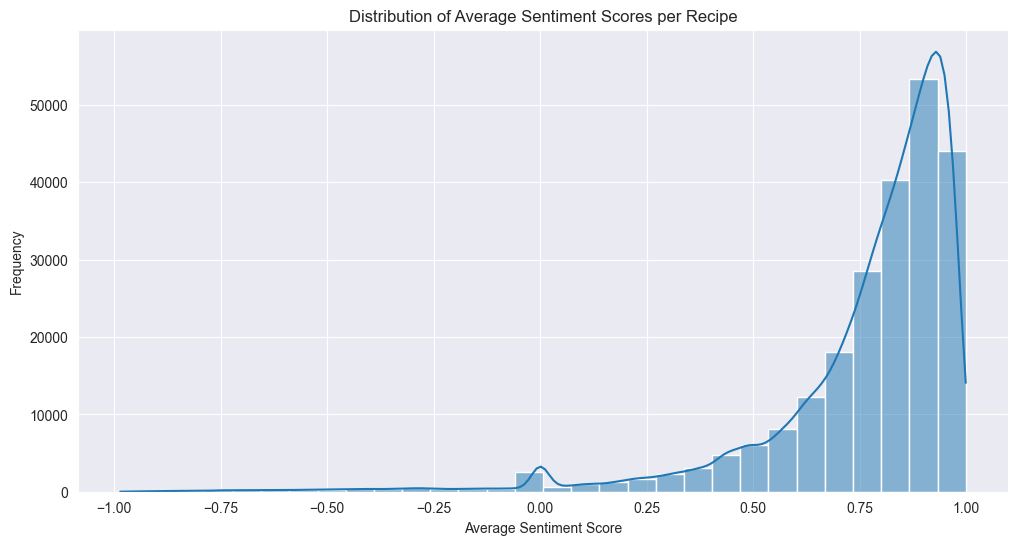

/var/folders/9p/pz2gm6b53b938gprkjnpppzr0000gn/T/ipykernel_73394/3208881922.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='average_sentiment_score', y='tags', data=top_positive_tags, palette='coolwarm')


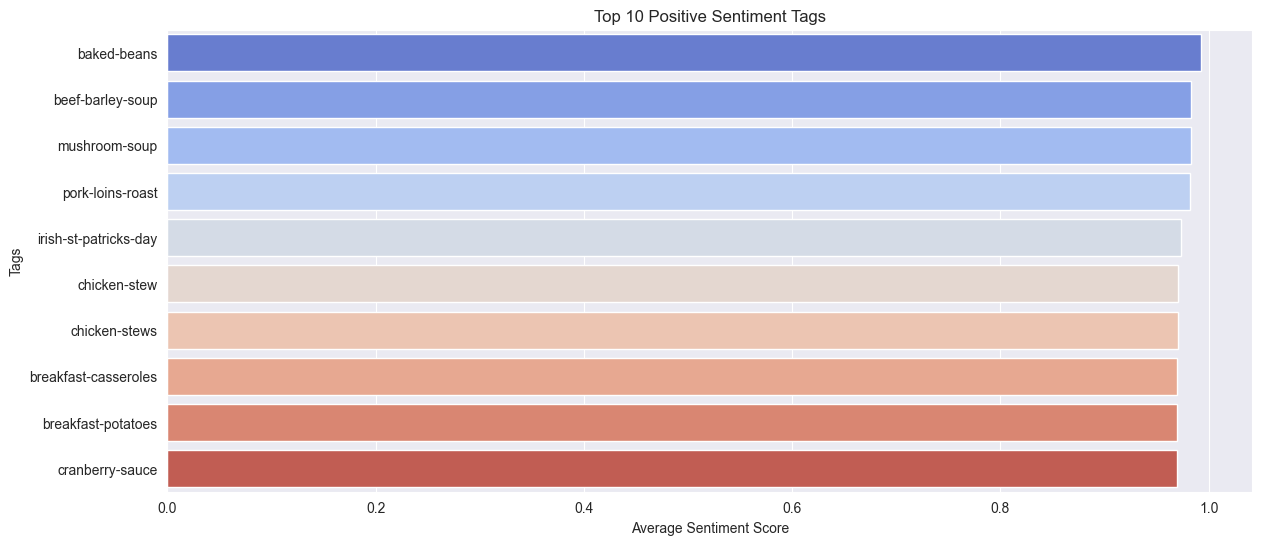

/var/folders/9p/pz2gm6b53b938gprkjnpppzr0000gn/T/ipykernel_73394/3208881922.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='average_sentiment_score', y='tags', data=top_negative_tags, palette='coolwarm')


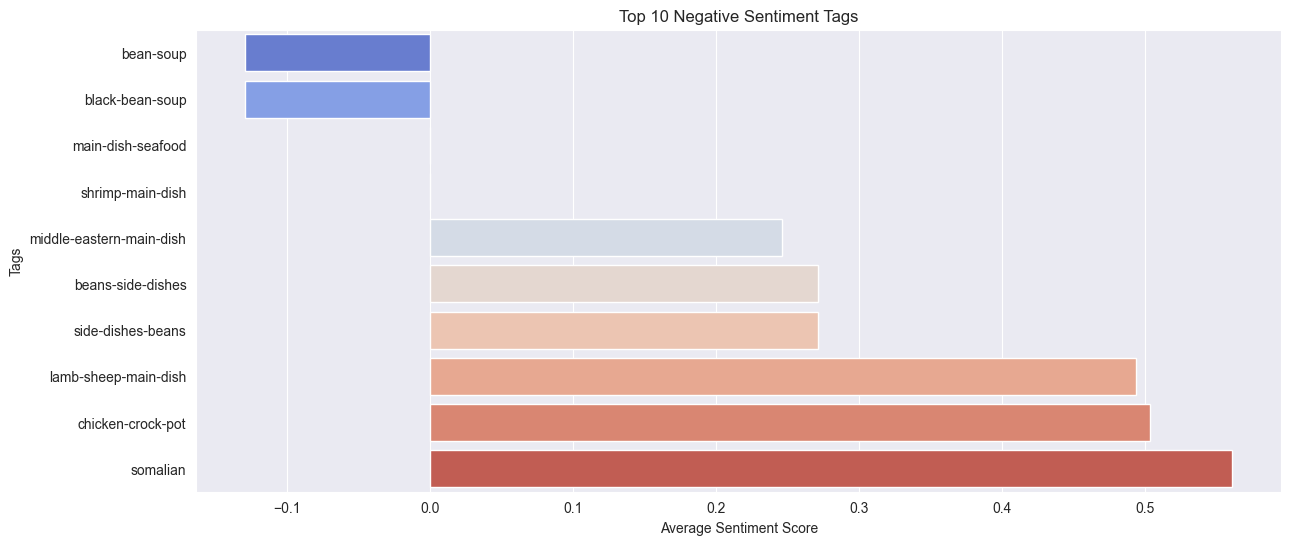

In [24]:

import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
recipes_df = pd.read_csv('RAW_recipes.csv')
interactions_df = pd.read_csv('RAW_interactions.csv')

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to calculate sentiment polarity score
def calculate_sentiment(review):
    if pd.isna(review):
        return 0  # Treat missing reviews as neutral with a score of 0
    return analyzer.polarity_scores(review)['compound']

# Apply sentiment analysis to each review
interactions_df['sentiment_score'] = interactions_df['review'].apply(calculate_sentiment)

# Calculate average sentiment score per recipe
recipe_sentiment = interactions_df.groupby('recipe_id')['sentiment_score'].mean().reset_index()
recipe_sentiment.columns = ['recipe_id', 'average_sentiment_score']

# Merge the average sentiment score back with recipe data to analyze tags
recipes_with_sentiment = recipes_df.merge(recipe_sentiment, left_on='id', right_on='recipe_id', how='left')

# Extract tags and calculate average sentiment per tag
recipes_with_sentiment['tags'] = recipes_with_sentiment['tags'].apply(lambda x: eval(x) if pd.notna(x) else [])
tag_sentiments = recipes_with_sentiment.explode('tags').groupby('tags')['average_sentiment_score'].mean().reset_index()
tag_sentiments = tag_sentiments.dropna()

# Visualize average sentiment scores for recipes and tags

# Plot 1: Distribution of Average Sentiment Scores per Recipe
plt.figure(figsize=(12, 6))
sns.histplot(recipe_sentiment['average_sentiment_score'], bins=30, kde=True)
plt.title('Distribution of Average Sentiment Scores per Recipe')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Frequency')
plt.show()

# Plot 2: Top Positive and Negative Tags
top_positive_tags = tag_sentiments.nlargest(10, 'average_sentiment_score')
top_negative_tags = tag_sentiments.nsmallest(10, 'average_sentiment_score')

plt.figure(figsize=(14, 6))
sns.barplot(x='average_sentiment_score', y='tags', data=top_positive_tags, palette='coolwarm')
plt.title('Top 10 Positive Sentiment Tags')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Tags')
plt.show()

plt.figure(figsize=(14, 6))
sns.barplot(x='average_sentiment_score', y='tags', data=top_negative_tags, palette='coolwarm')
plt.title('Top 10 Negative Sentiment Tags')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Tags')
plt.show()


In [1]:
#Task 5
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load the dataset
recipes_df = pd.read_csv('RAW_recipes_filtered.csv')

# Preprocess the ingredients column
# Join the list of ingredients into a single string for each recipe
recipes_df['ingredients_text'] = recipes_df['ingredients'].apply(lambda x: ' '.join(eval(x)) if pd.notna(x) else '')

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(recipes_df['ingredients_text'])

# Compute the cosine similarity matrix
cosine_sim_matrix = cosine_similarity(tfidf_matrix)

# Convert the similarity matrix to a DataFrame for easy lookup
similarity_df = pd.DataFrame(cosine_sim_matrix, index=recipes_df['id'], columns=recipes_df['id']).round(3)

# Save the dataset similarity_df
similarity_df.to_csv('/Users/marcovihelmo/Documents/Oulu_uni/CSE_Master/Courses/1st_P/NLP/project/Project_18/Q5/ingredient_similarity_matrix.csv', index=0)

# Display top 5 rows of the similarity DataFrame
print("Recipe Similarity Matrix (Top 5 Rows):")
print(similarity_df.head(12))

# Example: Check similarity of a particular recipe with others
recipe_id = recipes_df['id'][0]  # Using the first recipe ID as an example
print(f"\nTop 5 Similar Recipes to Recipe ID {recipe_id}:")
print(similarity_df[recipe_id].sort_values(ascending=False)[1:6])  # Exclude self-comparison

Recipe Similarity Matrix (Top 5 Rows):
id     67547   63986   43026   23933   54100   67664   25775   90921   58224   \
id                                                                              
67547   1.000   0.179   0.062     0.0   0.103   0.000   0.054   0.008   0.096   
63986   0.179   1.000   0.025     0.0   0.127   0.000   0.092   0.028   0.116   
43026   0.062   0.025   1.000     0.0   0.038   0.000   0.063   0.039   0.027   
23933   0.000   0.000   0.000     1.0   0.000   0.000   0.000   0.000   0.000   
54100   0.103   0.127   0.038     0.0   1.000   0.035   0.093   0.016   0.101   
67664   0.000   0.000   0.000     0.0   0.035   1.000   0.087   0.000   0.000   
25775   0.054   0.092   0.063     0.0   0.093   0.087   1.000   0.000   0.048   
90921   0.008   0.028   0.039     0.0   0.016   0.000   0.000   1.000   0.013   
58224   0.096   0.116   0.027     0.0   0.101   0.000   0.048   0.013   1.000   
22526   0.053   0.000   0.000     0.0   0.000   0.000   0.000   0.000 

In [2]:
#Task 6
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load the dataset
recipes_df = pd.read_csv('RAW_recipes_filtered.csv')

# Preprocess the tags column
# Join the list of tags into a single string for each recipe
recipes_df['tags_text'] = recipes_df['tags'].apply(lambda x: ' '.join(eval(x)) if pd.notna(x) else '')

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(recipes_df['tags_text'])

# Compute the cosine similarity matrix based on tags
cosine_sim_matrix = cosine_similarity(tfidf_matrix)

# Convert the similarity matrix to a DataFrame for easy lookup
similarity_df = pd.DataFrame(cosine_sim_matrix, index=recipes_df['id'], columns=recipes_df['id']).round(2)
# Save the dataset similarity_df
similarity_df.to_csv('Tag_Based_similarity_matrix.csv', index=False)

# Display top 5 rows of the similarity DataFrame
print("Recipe Tag-Based Similarity Matrix (Top 5 Rows):")
print(similarity_df.head())

# Example: Check similarity of a particular recipe with others based on tags
recipe_id = recipes_df['id'][0]  # Using the first recipe ID as an example
print(f"\nTop 5 Similar Recipes to Recipe ID {recipe_id} Based on Tags:")
print(similarity_df[recipe_id].sort_values(ascending=False)[1:6])  # Exclude self-comparison

Recipe Tag-Based Similarity Matrix (Top 5 Rows):
id     67547   63986   43026   23933   54100   67664   25775   90921   58224   \
id                                                                              
67547    1.00    0.13    0.25    0.08    0.06    0.05    0.33    0.21    0.07   
63986    0.13    1.00    0.05    0.05    0.09    0.03    0.11    0.11    0.12   
43026    0.25    0.05    1.00    0.23    0.07    0.15    0.34    0.22    0.13   
23933    0.08    0.05    0.23    1.00    0.09    0.38    0.21    0.12    0.17   
54100    0.06    0.09    0.07    0.09    1.00    0.07    0.08    0.12    0.13   

id     22526   ...  358200  181060  126852  70501   71659   71450   96811   \
id             ...                                                           
67547    0.20  ...    0.16    0.11    0.28    0.06    0.14    0.16    0.14   
63986    0.11  ...    0.05    0.04    0.05    0.05    0.07    0.16    0.05   
43026    0.18  ...    0.15    0.09    0.27    0.08    0.14    0.16    0

In [1]:
#Task 7

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load the dataset
recipes_df = pd.read_csv('RAW_recipes_filtered.csv')

# Preprocess the descriptions by filling NaNs with an empty string
recipes_df['description'] = recipes_df['description'].fillna('')

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(recipes_df['description'])

# Compute the cosine similarity matrix based on descriptions
cosine_sim_matrix = cosine_similarity(tfidf_matrix)

# Convert the similarity matrix to a DataFrame for easy lookup
similarity_df = pd.DataFrame(cosine_sim_matrix, index=recipes_df['id'], columns=recipes_df['id']).round(2)

# Save the dataset similarity_df
similarity_df.to_csv('review_similarity_matrix.csv', index=False)


# Display the top 5 rows of the similarity DataFrame
print("Recipe Description-Based Similarity Matrix (Top 5 Rows):")
print(similarity_df.head())

# Example: Check similarity of a particular recipe with others based on descriptions
recipe_id = recipes_df['id'][0]  # Using the first recipe ID as an example
print(f"\nTop 5 Similar Recipes to Recipe ID {recipe_id} Based on Descriptions:")
print(similarity_df[recipe_id].sort_values(ascending=False)[1:6])  # Exclude self-comparison

Recipe Description-Based Similarity Matrix (Top 5 Rows):
id       67547     63986   43026     23933   54100     67664     25775   \
id                                                                        
67547  1.000000  0.031007     0.0  0.081615     0.0  0.000000  0.036697   
63986  0.031007  1.000000     0.0  0.051445     0.0  0.000000  0.022229   
43026  0.000000  0.000000     1.0  0.000000     0.0  0.000000  0.000000   
23933  0.081615  0.051445     0.0  1.000000     0.0  0.055825  0.000000   
54100  0.000000  0.000000     0.0  0.000000     1.0  0.000000  0.031320   

id       90921     58224     22526   ...    358200    181060    126852  \
id                                   ...                                 
67547  0.022625  0.000000  0.011336  ...  0.010579  0.104670  0.010836   
63986  0.050878  0.000000  0.000000  ...  0.000000  0.055746  0.014573   
43026  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
23933  0.059344  0.000000  0.061111  ...  0.000

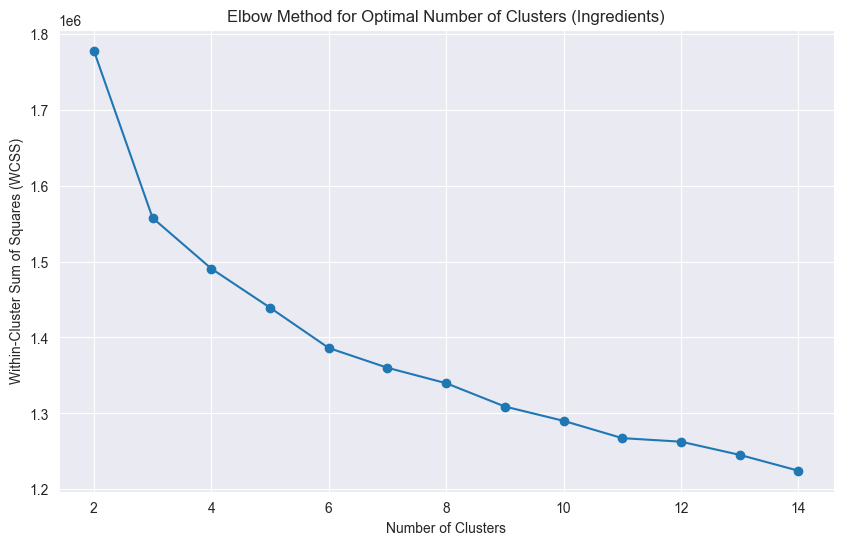

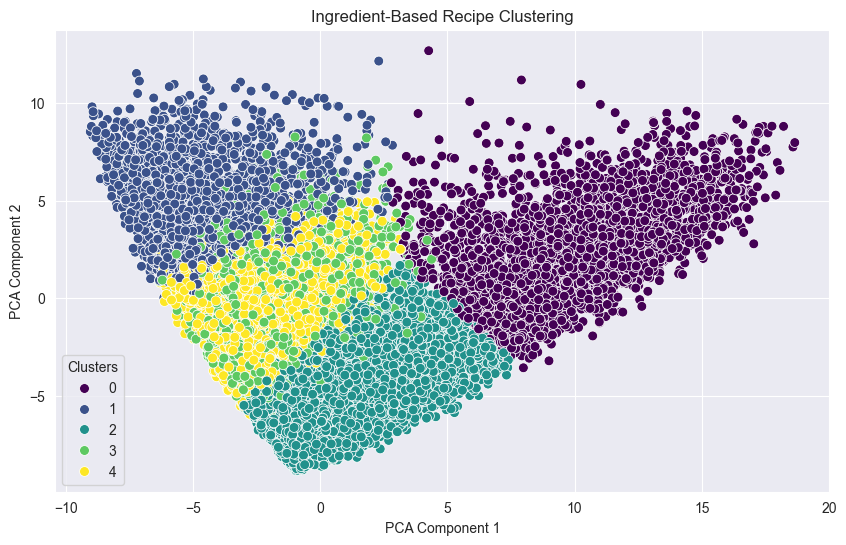

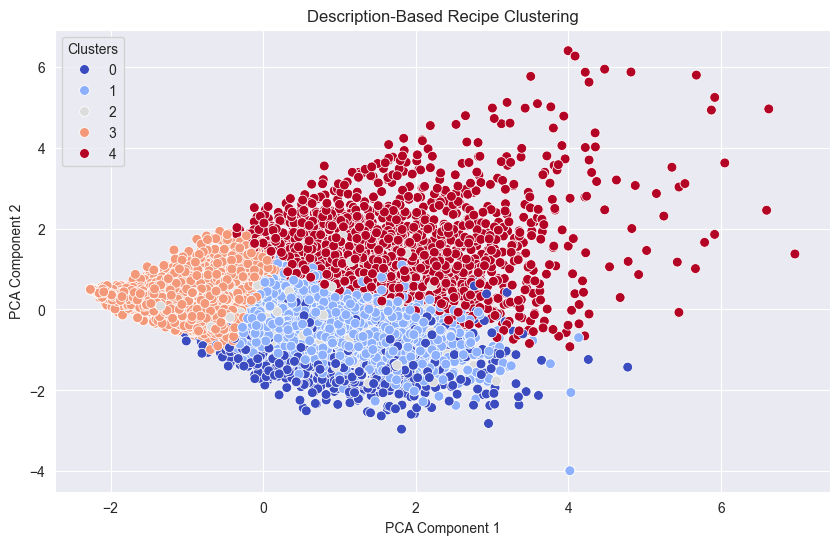

In [3]:
#Task 8
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA


# Load the dataset
recipes_df = pd.read_csv('RAW_recipes_filtered.csv')

# Preprocess the ingredients column
# Join the list of ingredients into a single string for each recipe
recipes_df['ingredients_text'] = recipes_df['ingredients'].apply(lambda x: ' '.join(eval(x)) if pd.notna(x) else '')

# Initialize TF-IDF Vectorizer
tfidf_vectorizer_in = TfidfVectorizer()
tfidf_matrix_in= tfidf_vectorizer_in.fit_transform(recipes_df['ingredients_text'])

# Compute the cosine similarity matrix
cosine_sim_matrix_in = cosine_similarity(tfidf_matrix_in)

# Convert the similarity matrix to a DataFrame for easy lookup
similarity_df_in = pd.DataFrame(cosine_sim_matrix_in, index=recipes_df['id'], columns=recipes_df['id'])



# Load the dataset
recipes_df_1 = pd.read_csv('RAW_recipes_filtered.csv')

# Preprocess the descriptions by filling NaNs with an empty string
recipes_df_1['description'] = recipes_df_1['description'].fillna('')

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer_re = TfidfVectorizer(stop_words='english')
tfidf_matrix_re= tfidf_vectorizer_re.fit_transform(recipes_df_1['description'])

# Compute the cosine similarity matrix based on descriptions
cosine_sim_matrix_re = cosine_similarity(tfidf_matrix_re)

# Convert the similarity matrix to a DataFrame for easy lookup
similarity_df_re = pd.DataFrame(cosine_sim_matrix_re, index=recipes_df_1['id'], columns=recipes_df_1['id'])



# Load ingredient-based similarity matrix
ingredient_similarity_df = similarity_df_in

# Load description-based similarity matrix
description_similarity_df = similarity_df_re

# the elbow method
wcss = []
range_clusters = range(2, 15)  # Range of cluster numbers to try

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(ingredient_similarity_df)
    wcss.append(kmeans.inertia_)  # Inertia is WCSS

# Plot the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(range_clusters, wcss, marker='o')
plt.title("Elbow Method for Optimal Number of Clusters (Ingredients)")
plt.xlabel("Number of Clusters")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.show()

# Number of clusters 
num_clusters = 5

# K-Means Clustering on Ingredient Similarity
kmeans_ingredient = KMeans(n_clusters=num_clusters, random_state=42)
ingredient_clusters = kmeans_ingredient.fit_predict(ingredient_similarity_df)

# K-Means Clustering on Description Similarity
kmeans_description = KMeans(n_clusters=num_clusters, random_state=42)
description_clusters = kmeans_description.fit_predict(description_similarity_df)



ingredient_clusters_df = pd.DataFrame(ingredient_clusters)
description_clusters_df = pd.DataFrame(description_clusters)

# Save Ingredients_cluster
ingredient_clusters_df.to_csv('ingredient_clusters.csv', index=False, header=0)
description_clusters_df.to_csv('description_clusters.csv', index=False, header=0)


# Adding cluster labels to each recipe in the similarity DataFrames
ingredient_similarity_df['ingredient_cluster'] = ingredient_clusters
description_similarity_df['description_cluster'] = description_clusters

# Visualizing Clusters with PCA for dimensionality reduction
# Using PCA for the ingredient-based clustering
pca = PCA(n_components=2)
ingredient_pca = pca.fit_transform(ingredient_similarity_df.drop(columns=['ingredient_cluster']))

# Plot Ingredient-based Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=ingredient_pca[:, 0], y=ingredient_pca[:, 1], hue=ingredient_clusters, palette='viridis', s=50)
plt.title("Ingredient-Based Recipe Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Clusters")
plt.show()

# Using PCA for the description-based clustering
description_pca = pca.fit_transform(description_similarity_df.drop(columns=['description_cluster']))

# Plot Description-based Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=description_pca[:, 0], y=description_pca[:, 1], hue=description_clusters, palette='coolwarm', s=50)
plt.title("Description-Based Recipe Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Clusters")
plt.show()

/var/folders/9p/pz2gm6b53b938gprkjnpppzr0000gn/T/ipykernel_10808/2208543525.py:114: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_summary['description_cluster'], y=cluster_summary['rating'], palette='viridis')


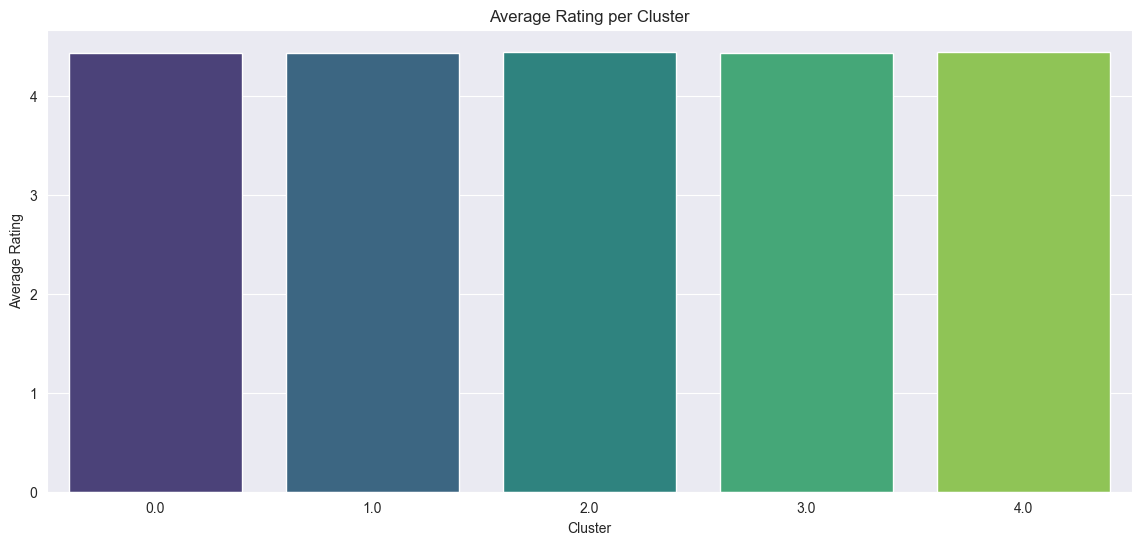

/var/folders/9p/pz2gm6b53b938gprkjnpppzr0000gn/T/ipykernel_10808/2208543525.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_summary['description_cluster'], y=cluster_summary['sentiment_score'], palette='coolwarm')


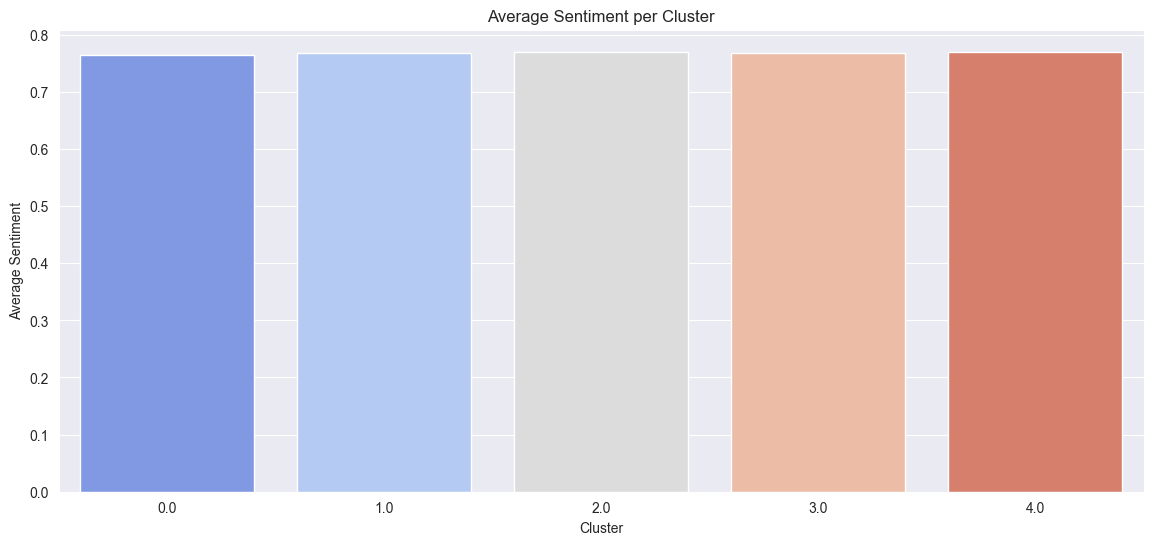


Cluster 0.0
Top Tags: {'course': np.int64(39230), 'dietary': np.int64(35648), 'less': np.int64(49969), 'low': np.int64(56562), 'main': np.int64(47874), 'make': np.int64(41712), 'or': np.int64(53937), 'preparation': np.int64(41020), 'time': np.int64(40613), 'to': np.int64(46820)}
Top Ingredients: {'butter': np.int64(13043), 'cheese': np.int64(15466), 'flour': np.int64(11821), 'garlic': np.int64(15067), 'ground': np.int64(15454), 'oil': np.int64(13005), 'onion': np.int64(12326), 'pepper': np.int64(21634), 'salt': np.int64(25218), 'sugar': np.int64(20090)}
Topics: {'Topic 1': ['flavor', 'time', 'family', 'like', 'easy', 'sauce', 'use', 'just', 'make', 'recipe'], 'Topic 2': ['cabrales', 'carlton', 'erasing', 'pine', 'asia', 'stash', 'forming', 'towels', 'tipping', 'danielle'], 'Topic 3': ['add', 'like', 'great', 'family', 'time', 'use', 'easy', 'just', 'make', 'recipe']}
Average Rating: 4.43
Average Sentiment: 0.77

Cluster 1.0
Top Tags: {'course': np.int64(225289), 'dietary': np.int64(20

In [4]:
# Task 9
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# Load the datasets 
recipes_df = pd.read_csv('RAW_recipes_filtered.csv')
interactions_df = pd.read_csv('RAW_interactions_filtered.csv')

# Sample clusters data (from previous clustering results on ingredients or descriptions)
description_clusters = pd.read_csv('description_clusters.csv')
ingredient_clusters = pd.read_csv('ingredient_clusters.csv')

recipes_df['description_cluster'] = description_clusters  
recipes_df['ingredient_cluster'] = ingredient_clusters 

# Step 1: Aggregate key features by clusters
# Merge recipe ratings with recipes
recipes_with_reviews = recipes_df.merge(interactions_df, left_on='id', right_on='recipe_id', how='left')
recipes_with_reviews.to_csv('interaction_with_clusters.csv', index=False)

# Calculate average sentiment and average rating for each cluster
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to calculate sentiment polarity score
def calculate_sentiment(review):
    if pd.isna(review):
        return 0  # Treat missing reviews as neutral with a score of 0
    return analyzer.polarity_scores(review)['compound']

# Apply sentiment analysis to each review
recipes_with_reviews['sentiment_score'] = recipes_with_reviews['review'].apply(calculate_sentiment)

def safe_eval(item):
    try:
        # Attempt to parse as a Python literal (e.g., a list or dict)
        return ast.literal_eval(item)
    except (ValueError, SyntaxError):
        # If it fails, return the item as is (assume it's plain text)
        return item

cluster_summary = recipes_with_reviews.groupby('description_cluster').agg({
    'rating': 'mean',
    'sentiment_score': 'mean',
    'tags': lambda x: ' '.join(
        [str(tag) for tags in x.dropna() for tag in safe_eval(tags) if isinstance(tag, str)]
    ),
    'ingredients': lambda x: ' '.join(
        [str(ingredient) for ingredients in x.dropna() for ingredient in safe_eval(ingredients) if isinstance(ingredient, str)]
    ),
    'description': lambda x: ' '.join(
        [str(description) for description in x.dropna()  if isinstance(description, str)]
    )
}).reset_index()

ingredient_cluster_summary = recipes_with_reviews.groupby('ingredient_cluster').agg({
    'rating': 'mean',
    'sentiment_score': 'mean',
    'tags': lambda x: ' '.join(
        [str(tag) for tags in x.dropna() for tag in safe_eval(tags) if isinstance(tag, str)]
    ),
    'ingredients': lambda x: ' '.join(
        [str(ingredient) for ingredients in x.dropna() for ingredient in safe_eval(ingredients) if isinstance(ingredient, str)]
    ),
    'description': lambda x: ' '.join(
        [str(description) for description in x.dropna()  if isinstance(description, str)]
    )
}).reset_index()

# Step 2: Topic Modeling on Descriptions using LDA
# Apply LDA on the combined descriptions for each cluster
def lda_topic_modeling(text_data, num_topics=3):
    # Vectorize text data
    vectorizer = CountVectorizer(stop_words='english', max_features=5000)
    doc_term_matrix = vectorizer.fit_transform(text_data)
    
    # Apply LDA
    lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda_model.fit(doc_term_matrix)
    
    # Extract topics
    topics = {}
    for idx, topic in enumerate(lda_model.components_):
        top_words = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]]
        topics[f"Topic {idx+1}"] = top_words
    return topics

# Perform LDA for each cluster
cluster_summary['topics'] = cluster_summary['description'].apply(lambda x: lda_topic_modeling([x]))
ingredient_cluster_summary['topics'] = ingredient_cluster_summary['description'].apply(lambda x: lda_topic_modeling([x]))

# Step 3: Extract most frequent tags and ingredients
def get_most_frequent_terms(text, top_n=10):
    vectorizer = CountVectorizer(max_features=top_n)
    term_matrix = vectorizer.fit_transform([text])
    terms = vectorizer.get_feature_names_out()
    counts = term_matrix.toarray().sum(axis=0)
    return dict(zip(terms, counts))

cluster_summary['top_tags'] = cluster_summary['tags'].apply(get_most_frequent_terms)
cluster_summary['top_ingredients'] = cluster_summary['ingredients'].apply(get_most_frequent_terms)

ingredient_cluster_summary['top_tags'] = ingredient_cluster_summary['tags'].apply(get_most_frequent_terms)
ingredient_cluster_summary['top_ingredients'] = ingredient_cluster_summary['ingredients'].apply(get_most_frequent_terms)

# Step 4: Visualize Results
# Visualize average sentiment and rating per cluster
plt.figure(figsize=(14, 6))
sns.barplot(x=cluster_summary['description_cluster'], y=cluster_summary['rating'], palette='viridis')
plt.title('Average Rating per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Rating')
plt.show()

plt.figure(figsize=(14, 6))
sns.barplot(x=cluster_summary['description_cluster'], y=cluster_summary['sentiment_score'], palette='coolwarm')
plt.title('Average Sentiment per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Sentiment')
plt.show()

# Displaying topics, top tags, and ingredients for each cluster
for idx, row in cluster_summary.iterrows():
    print(f"\nCluster {row['description_cluster']}")
    print(f"Top Tags: {row['top_tags']}")
    print(f"Top Ingredients: {row['top_ingredients']}")
    print(f"Topics: {row['topics']}")
    print(f"Average Rating: {row['rating']:.2f}")
    print(f"Average Sentiment: {row['sentiment_score']:.2f}")
    
for idx, row in ingredient_cluster_summary.iterrows():
    print(f"\nCluster {row['ingredient_cluster']}")
    print(f"Top Tags: {row['top_tags']}")
    print(f"Top Ingredients: {row['top_ingredients']}")
    print(f"Topics: {row['topics']}")
    print(f"Average Rating: {row['rating']:.2f}")
    print(f"Average Sentiment: {row['sentiment_score']:.2f}")
    
# Initialize an empty list to collect row data
output_data = []
ingredient_output_data = []

# Iterate over the rows of the DataFrame
for idx, row in cluster_summary.iterrows():
    # Collect the output data for each row
    output_data.append({
        'Cluster': row['description_cluster'],
        'Top Tags': row['top_tags'],
        'Top Ingredients': row['top_ingredients'],
        'Topics': row['topics'],
        'Average Rating': round(row['rating'], 2),
        'Average Sentiment': round(row['sentiment_score'], 2)
    })

for idx, row in ingredient_cluster_summary.iterrows():
    # Collect the output data for each row
    ingredient_output_data.append({
        'Cluster': row['ingredient_cluster'],
        'Top Tags': row['top_tags'],
        'Top Ingredients': row['top_ingredients'],
        'Topics': row['topics'],
        'Average Rating': round(row['rating'], 2),
        'Average Sentiment': round(row['sentiment_score'], 2)
    })
# Convert the collected data into a DataFrame
output_df = pd.DataFrame(output_data)
ingredient_output_df = pd.DataFrame(ingredient_output_data)

# Save the DataFrame to a CSV file
output_df.to_csv('cluster_summary_output.csv', index=False)
ingredient_output_df.to_csv('ingredient_cluster_summary_output.csv', index=False)

# Optionally, print the DataFrame to check
print(output_df)
print(ingredient_output_df)

In [6]:
#Task 10
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity



# Load the interactions dataset with user ratings
interactions_df = pd.read_csv('RAW_interactions_filtered.csv')

# Split data into training and test sets (80% training, 20% testing for each user)
train_data = []
test_data = []


for user_id, user_ratings in interactions_df.groupby('user_id'):
    if len(user_ratings) < 5:  # threshold that makes sense for the data
        continue  # Skip or handle users with very few ratings
    # Split ratings for each user
    user_train, user_test = train_test_split(user_ratings, test_size=0.2, random_state=42)
    train_data.append(user_train)
    test_data.append(user_test)

# Concatenate user train and test sets into single DataFrames
train_df = pd.concat(train_data)
test_df = pd.concat(test_data)

def predict_rating(user_id, recipe_id, train_ratings, similarity_matrix):
    # Filter the user's ratings from the training set
    user_train_ratings = train_ratings[train_ratings['user_id'] == user_id]
    rated_recipes = user_train_ratings['recipe_id'].values
    ratings = user_train_ratings['rating'].values
    
    # Find similarity scores between target recipe and all recipes user rated in training set
    similarities = similarity_matrix.loc[recipe_id, rated_recipes].values
    
    # Weighted average of the ratings based on similarity
    if similarities.sum() > 0:
        predicted_rating = np.dot(similarities, ratings) / similarities.sum()
    else:
        predicted_rating = np.mean(ratings)  # Default to average rating if no similarities

    return predicted_rating



def evaluate_model(test_df, train_df, similarity_matrix):
    true_ratings = []
    predicted_ratings = []

    for _, row in test_df.iterrows():
        user_id = row['user_id']
        recipe_id = row['recipe_id']
        true_rating = row['rating']
        
        # Predict rating based on the similarity matrix
        predicted_rating = predict_rating(user_id, recipe_id, train_df, similarity_matrix)
        
        # Store true and predicted ratings
        true_ratings.append(true_rating)
        predicted_ratings.append(predicted_rating)
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(true_ratings, predicted_ratings).round(2)
    rmse = np.sqrt(mean_squared_error(true_ratings, predicted_ratings)).round(2)
    return mae, rmse


# Load the dataset
recipes_df = pd.read_csv('RAW_recipes_filtered.csv')

# Preprocess the ingredients column
# Join the list of ingredients into a single string for each recipe
recipes_df['ingredients_text'] = recipes_df['ingredients'].apply(lambda x: ' '.join(eval(x)) if pd.notna(x) else '')

# Initialize TF-IDF Vectorizer
tfidf_vectorizer_in = TfidfVectorizer()
tfidf_matrix_in= tfidf_vectorizer_in.fit_transform(recipes_df['ingredients_text'])

# Compute the cosine similarity matrix
cosine_sim_matrix_in = cosine_similarity(tfidf_matrix_in)

# Convert the similarity matrix to a DataFrame for easy lookup
similarity_df_in = pd.DataFrame(cosine_sim_matrix_in, index=recipes_df['id'], columns=recipes_df['id'])


# Load the dataset
recipes_df_1 = pd.read_csv('RAW_recipes_filtered.csv')

# Preprocess the descriptions by filling NaNs with an empty string
recipes_df_1['description'] = recipes_df_1['description'].fillna('')

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer_re = TfidfVectorizer(stop_words='english')
tfidf_matrix_re= tfidf_vectorizer_re.fit_transform(recipes_df_1['description'])

# Compute the cosine similarity matrix based on descriptions
cosine_sim_matrix_re = cosine_similarity(tfidf_matrix_re)

# Convert the similarity matrix to a DataFrame for easy lookup
similarity_df_re = pd.DataFrame(cosine_sim_matrix_re, index=recipes_df_1['id'], columns=recipes_df_1['id'])

# Load the dataset
recipes_df_tag= pd.read_csv('RAW_recipes_filtered.csv')

# Preprocess the tags column
# Join the list of tags into a single string for each recipe
recipes_df_tag['tags_text'] = recipes_df_tag['tags'].apply(lambda x: ' '.join(eval(x)) if pd.notna(x) else '')

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer_tag = TfidfVectorizer()
tfidf_matrix_tag= tfidf_vectorizer_tag.fit_transform(recipes_df_tag['tags_text'])

# Compute the cosine similarity matrix based on tags
cosine_sim_matrix_tag = cosine_similarity(tfidf_matrix_tag)

# Convert the similarity matrix to a DataFrame for easy lookup
similarity_df_tag = pd.DataFrame(cosine_sim_matrix_tag, index=recipes_df_tag['id'], columns=recipes_df_tag['id'])

ingredient_similarity_df = similarity_df_in
description_similarity_df = similarity_df_tag
review_similarity_df = similarity_df_re

# Evaluate Tag and Ingredients-Based Similarity
mae_ingredients, rmse_ingredients = evaluate_model(test_df, train_df, ingredient_similarity_df)
print(f"Ingredients Similarity - MAE: {mae_ingredients:.4f}, RMSE: {rmse_ingredients:.4f}")

# Evaluate Description-Based Similarity
mae_description, rmse_description = evaluate_model(test_df, train_df, description_similarity_df)
print(f"Description Similarity - MAE: {mae_description:.4f}, RMSE: {rmse_description:.4f}")

# Evaluate Review-Based Similarity
mae_review, rmse_review = evaluate_model(test_df, train_df, review_similarity_df)
print(f"Review Similarity - MAE: {mae_review:.4f}, RMSE: {rmse_review:.4f}")

# Create a DataFrame to save the results
results_df = pd.DataFrame({
    'Model Based': ['Ingredients', 'Tag', 'Description'],
    'MAE': [mae_ingredients, mae_description, mae_review],
    'RMSE': [rmse_ingredients, rmse_description, rmse_review]
}).round(2)

# Save the DataFrame to a CSV file
results_df.to_csv('evaluation_results.csv', index=False)

Ingredients Similarity - MAE: 0.5300, RMSE: 0.9600
Description Similarity - MAE: 0.5300, RMSE: 0.9400
Review Similarity - MAE: 0.5400, RMSE: 0.9900


In [1]:
# Task 11
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split


# Load the interactions dataset with user ratings
interactions_df = pd.read_csv('RAW_interactions_filtered.csv')

# Split the dataset into training and test sets 
train_data = []
test_data = []


for user_id, user_ratings in interactions_df.groupby('user_id'):
    if len(user_ratings) < 5:  # threshold that makes sense for data
        continue  # Skip or handle users with very few ratings
    # Split ratings for each user
    user_train, user_test = train_test_split(user_ratings, test_size=0.2, random_state=42)
    train_data.append(user_train)
    test_data.append(user_test)

# Concatenate user train and test sets into single DataFrames
train_df = pd.concat(train_data)
test_df = pd.concat(test_data)

# Step 1: Calculate Pearson Correlation-based User Similarity
def calculate_user_similarity(train_df):
    # Pivot the training data to get a user-item rating matrix
    user_item_matrix = train_df.pivot(index='user_id', columns='recipe_id', values='rating')
    user_means = user_item_matrix.mean(axis=1)

    # Subtract the user's average rating from each rating to center data
    user_item_matrix_centered = user_item_matrix.sub(user_means, axis=0)

    # Calculate the Pearson correlation coefficient matrix between users
    user_similarity = user_item_matrix_centered.T.corr(method='pearson').fillna(0)
    return user_similarity

user_similarity = calculate_user_similarity(train_df)


def predict_rating(user_id, recipe_id, train_df, user_similarity, k=5):
    # Filter the user's ratings from the training set
    user_train_ratings = train_df[train_df['recipe_id'] == recipe_id]
    if user_train_ratings.empty:
        return np.nan  # If no ratings, we can't predict

    # Find similar users who have rated this recipe
    similarities = user_similarity[user_id]
    ratings_by_similar_users = user_train_ratings.set_index('user_id')['rating']

    # Keep only the top k most similar users who have rated the recipe
    similar_users = similarities[ratings_by_similar_users.index].nlargest(k)
    if similar_users.sum() == 0:
        return np.nan  # If no similar users, we can't predict

    # Calculate weighted average rating
    weighted_ratings = ratings_by_similar_users.loc[similar_users.index] * similar_users
    predicted_rating = weighted_ratings.sum() / similar_users.sum()
    return predicted_rating

def evaluate_collaborative_filtering(test_df, train_df, user_similarity):
    true_ratings = []
    predicted_ratings = []

    for _, row in test_df.iterrows():
        user_id = row['user_id']
        recipe_id = row['recipe_id']
        true_rating = row['rating']
        
        # Predict rating based on collaborative filtering
        predicted_rating = predict_rating(user_id, recipe_id, train_df, user_similarity)
        
        if not np.isnan(predicted_rating):
            # Store true and predicted ratings
            true_ratings.append(true_rating)
            predicted_ratings.append(predicted_rating)
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(true_ratings, predicted_ratings).round(2)
    rmse = np.sqrt(mean_squared_error(true_ratings, predicted_ratings)).round(2)
    return mae, rmse

# Run evaluation
mae, rmse = evaluate_collaborative_filtering(test_df, train_df, user_similarity)
print(f"Collaborative Filtering - MAE: {mae:.4f}, RMSE: {rmse:.4f}")


# Create a DataFrame to save the results
results_df = pd.DataFrame({
    'Model Based': ['Collaborative Filtering'],
    'MAE': [mae],
    'RMSE': [rmse]
}).round(2)

# Save the DataFrame to a CSV file
results_df.to_csv('/Users/marcovihelmo/Documents/Oulu_uni/CSE_Master/Courses/1st_P/NLP/project/Project_18/Q11/evaluation_results_11.csv', index=False)

Collaborative Filtering - MAE: 0.6100, RMSE: 1.6400
